__Вводные данные:__

Дана динамика покупки пользователями платных подписок в мобильном приложении с марта по октябрь 2018 года. 1 октября 2018 года вышла новая версия приложения. С 10.10.18 по 12.10.18 пользователи могли оформить подписку со скидкой. 

__Задача:__ 

Необходимо проанализировать рост выручки. Результат оформить в виде краткого отчета с визуализацией данных.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
%matplotlib inline

In [2]:
dynamic_purchase = pd.read_excel('result.xlsx', sheet_name=0, names=['Date', 'Revenue, $'], dtype={'Date': datetime})

Text(0, 0.5, 'Revenue, $')

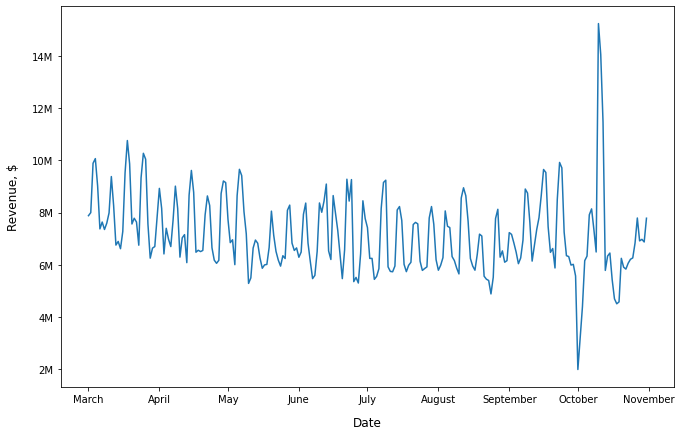

In [3]:
# график динамики общей выручки
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot()

x = dynamic_purchase['Date']
y = dynamic_purchase['Revenue, $']
ax.plot(x, y)

from matplotlib.ticker import FixedLocator
ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks().tolist()))
ax.set_xticklabels([calendar.month_name[i] for i in range(3, 12)])
ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks().tolist()))
ax.set_yticklabels([f'{i}M' for i in range(0, 17, 2)])

plt.xlabel('Date', labelpad=12, fontsize=12)
plt.ylabel('Revenue, $', labelpad=12, fontsize=12)

На первый взгляд, виден медленный спад. Даже после всплеска в октябре, который можно объяснить релизом новой версии приложения и/или приобретением подписки со скидкой, тенденция всё равно сохраняется.

In [16]:
# расчёт среднего значения выручки в каждый месяц данного периода
mean_revenue_lst = []
for nm in range(3, 11):
    sample = dynamic_purchase.loc[dynamic_purchase['Date'].dt.month==nm]
    mean_value = np.mean(sample['Revenue, $'])
    mean_revenue_lst.append(mean_value)
mean_revenue = pd.DataFrame({'Month': [calendar.month_name[i] for i in range(3, 11)], 'Mean, $': [round(i, 2) for i in mean_revenue_lst]})
_mean_revenue_ax = pd.DataFrame({'Month': [datetime.strptime(f'2018-{nm}-15', '%Y-%m-%d') for nm in range(3, 11)], 'Mean, $': mean_revenue_lst})

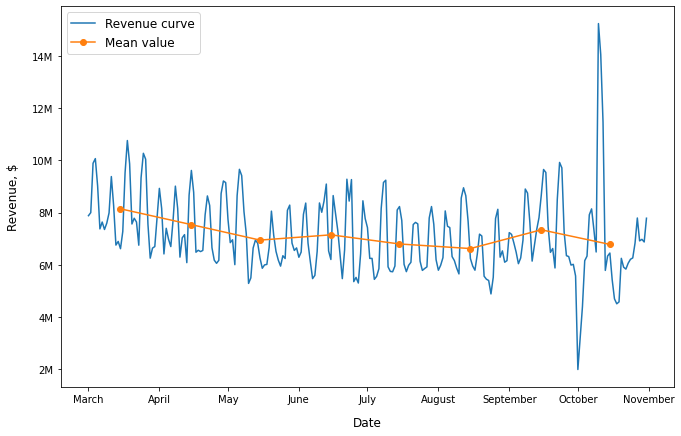

In [8]:
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot()

x = dynamic_purchase['Date']
y = dynamic_purchase['Revenue, $']
mx = mean_revenue_ax['Month']
my = mean_revenue_ax['Mean, $']
ax.plot(x, y, mx, my, 'o-')

from matplotlib.ticker import FixedLocator
ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks().tolist()))
ax.set_xticklabels([calendar.month_name[i] for i in range(3, 12)])
ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks().tolist()))
ax.set_yticklabels([f'{i}M' for i in range(0, 17, 2)])

plt.xlabel('Date', labelpad=12, fontsize=12)
plt.ylabel('Revenue, $', labelpad=12, fontsize=12)

plt.legend(['Revenue curve', 'Mean value'], fontsize=12)

Кривая среднего значения это показывает более чётко. 

In [9]:
# фунцкии для расчёта ключевых параметров анализа выручки

# расчёт цепного/базисного прироста, где y2 - показатель за текущий месяц, y1 - показатель за предыдущий месяц/базисный показатель
increment = lambda y1, y2: round(y2 - y1, 2)

# расчёт цепного/базисного темпа роста
growth_rate = lambda y1, y2: round((y2 / y1) * 100, 2)

# расчёт цепного/базисного темпа прироста
increment_rate = lambda y1, y2: growth_rate(y1, y2) - 100


# расчёт среднего темпа роста, где n - количество месяцев, yn - показатель за текущий месяц, y0 - базисный показатель
mean_growth_rate = lambda n, y0, yn: round(pow((yn / y0), (1 / (n - 1))), 2) * 100
    
# расчёт среднего темпа прироста
mean_increment_rate = lambda n, y0, yn: mean_growth_rate(n, y0, yn) - 100

In [10]:
parameters = pd.DataFrame({'Period': [calendar.month_name[i] for i in range(4, 11)],
                           'Increment, $ (chain)': [increment(mean_revenue['Mean, $'].values[i], mean_revenue['Mean, $'].values[i + 1]) for i in range(7)],               
                           'Growth rate, % (chain)': [growth_rate(mean_revenue['Mean, $'].values[i], mean_revenue['Mean, $'].values[i + 1]) for i in range(7)], 
                           'Increment rate, % (chain)': [increment_rate(mean_revenue['Mean, $'].values[i], mean_revenue['Mean, $'].values[i + 1]) for i in range(7)],
                           'Increment rate, % (basic: March)': [increment_rate(mean_revenue['Mean, $'].values[0], mean_revenue['Mean, $'].values[i]) for i in range(1, 8)]})

In [11]:
parameters

,Period,"Increment, $ (chain)","Growth rate, % (chain)","Increment rate, % (chain)","Increment rate, % (basic: March)"
0,April,-606571.68,92.55,-7.45,-7.45
1,May,-593366.77,92.13,-7.87,-14.74
2,June,202093.40,102.91,2.91,-12.26
3,July,-350405.98,95.09,-4.91,-16.56
4,August,-175521.49,97.42,-2.58,-18.72
5,September,719458.41,110.87,10.87,-9.88
6,October,-560708.67,92.36,-7.64,-16.77


In [12]:
# расчёт среднего темпа прироста
mean_increment_rate(8, mean_revenue['Mean, $'].values[0], mean_revenue['Mean, $'].values[7])

-3.0

Более детальный анализ показал, что в данный период действительно наблюдалась рецессия выручки (это можно проследить по базисному темпу прироста) и составила в среднем 3 % от выручки в начале периода. Рост наблюдался лишь в июне и сентябре (не смотря на резкий спад в конце месяца и минимальный за весь период), что нивелировало рецессию. Также видно, что выпуск новой версии и скидочное предложение на ситуацию в целом не повлияли.

In [13]:
new_version = dynamic_purchase.loc[dynamic_purchase['Date'].dt.month == 10]
discont = dynamic_purchase[(dynamic_purchase.Date >= datetime(2018, 10, 10)) & (dynamic_purchase.Date <= datetime(2018, 10, 12))]

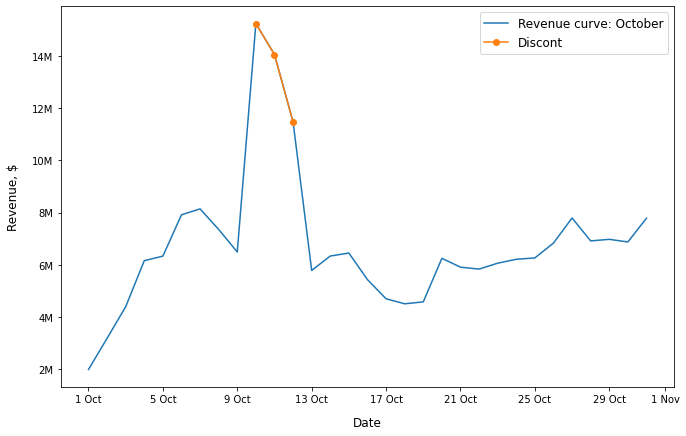

In [14]:
# график выручки за октябрь с кривой, соответсвующей скидке
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot()

nvx = new_version['Date']
nvy = new_version['Revenue, $']
disx = discont['Date']
disy = discont['Revenue, $']
ax.plot(nvx, nvy, disx, disy, 'o-')

from matplotlib.ticker import FixedLocator
ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks().tolist()))
ax.set_xticklabels([f'{day} Oct' for day in range(1, 31, 4)] + ['1 Nov'])
ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks().tolist()))
ax.set_yticklabels([f'{i}M' for i in range(0, 17, 2)])

plt.xlabel('Date', labelpad=12, fontsize=12)
plt.ylabel('Revenue, $', labelpad=12, fontsize=12)

plt.legend(['Revenue curve: October', 'Discont'], fontsize=12)

По графику выручки за октябрь видно, что максимум (как месяца, так и периода в целом) приходится на день, когда подписка была доступна со скидкой. Однако в последующие дни скидочного предложения наблюдался спад.